In [18]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np

In [3]:
# G(z) -- GENERATOR
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

In [4]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

In [5]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


In [7]:
def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda(), volatile=True)

    G.eval()
    if isFix:
        test_images = G(fixed_z_)
    else:
        test_images = G(z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [8]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 20

In [9]:
# data_loader
img_size = 64
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.5/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Processing...
Done!


In [ ]:
# train_loader.data

In [10]:
# network
G = generator(128)
D = discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [11]:
# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

In [12]:
# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [13]:
# results save folder
if not os.path.isdir('MNIST_DCGAN_results'):
    os.mkdir('MNIST_DCGAN_results')
if not os.path.isdir('MNIST_DCGAN_results/Random_results'):
    os.mkdir('MNIST_DCGAN_results/Random_results')
if not os.path.isdir('MNIST_DCGAN_results/Fixed_results'):
    os.mkdir('MNIST_DCGAN_results/Fixed_results')

In [14]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
num_iter = 0

In [19]:
print('training start!')
start_time = time.time()
for epoch in range(train_epoch-4):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in train_loader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())
        G_result = G(z_)

        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        # D_losses.append(D_train_loss.data[0])
        D_losses.append(D_train_loss.data[0])

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data[0])

        num_iter += 1
    
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    p = 'MNIST_DCGAN_results/Random_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    fixed_p = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=p, isFix=False)
    show_result((epoch+1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

training start!
0
3.116257176057362 0.5683808841113088
1
3.4550060752961937 0.47290813111896707
2
3.5096890973939954 0.4977594440393865
3
3.409795150565885 0.5286748471147598
4
3.3796697952996517 0.47692563010256556
5
3.4436400378309586 0.4657925710495093
6
3.991146556473077 0.3224607467262158
7
3.3953603198017075 0.5501036892619247
8
3.754974347656406 0.42189560033110923
9
3.726423527896484 0.42810605948906083
10
3.961014992239744 0.3198930212318389
11
3.336749071179371 0.586820012099469
12
3.8496607270226804 0.3302530576544466
13
4.202248999877259 0.3927110215144625
14
3.8774321739996784 0.3972678055534008
15
3.745596110908144 0.38960526783519717


In [21]:
z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
z_ = Variable(z_.cuda())
G_result = G(z_)

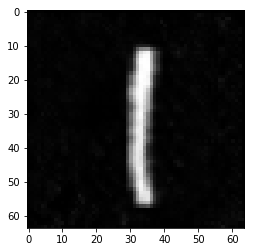

In [32]:
plt.imshow(G_result.cpu().data.numpy()[3,0], cmap="gray")

In [30]:
G_result.cpu().data.numpy().shape

(96, 1, 64, 64)

## Classifier

In [33]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(10 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [34]:
net = Net()
import pickle
net.load_state_dict(pickle.load(open("trained_mnist_classifier.pkl","rb")))

In [81]:
# list(net.parameters())
net.cuda()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=250, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [85]:
input = torch.FloatTensor(RescaleTrans(Image.fromarray(G_result[0,0].cpu().mul(0.5).add(0.5).mul(255).byte().numpy())).numpy())
input = Variable(input.cuda())

_,pred = torch.max(net(torch.unsqueeze(input,0)),1)
pred

Variable containing:
 3
[torch.cuda.LongTensor of size (1,) (GPU 0)]

In [79]:
from PIL import Image
RescaleTrans = transforms.Compose([
transforms.Scale(28),
transforms.ToTensor(),
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
torch.FloatTensor(RescaleTrans(Image.fromarray(G_result[0,0].cpu().mul(0.5).add(0.5).mul(255).byte().numpy())).numpy())

/usr/local/lib/python3.5/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")



(0 ,.,.) = 

Columns 0 to 8 
   0.0039  0.0078  0.0039  0.0039  0.0000  0.0078  0.0039  0.0039  0.0078
  0.0078  0.0118  0.0078  0.0118  0.0078  0.0157  0.0118  0.0078  0.0078
  0.0078  0.0118  0.0118  0.0235  0.0235  0.0196  0.0157  0.0118  0.0078
  0.0118  0.0118  0.0078  0.0157  0.0275  0.0157  0.0196  0.0157  0.0157
  0.0118  0.0157  0.0118  0.0118  0.0196  0.0235  0.0196  0.0196  0.0353
  0.0078  0.0157  0.0157  0.0118  0.0078  0.0235  0.0196  0.0157  0.0196
  0.0078  0.0196  0.0196  0.0157  0.0118  0.0196  0.0314  0.0196  0.0157
  0.0118  0.0196  0.0118  0.0078  0.0157  0.0196  0.0118  0.0118  0.0118
  0.0118  0.0157  0.0157  0.0078  0.0118  0.0353  0.0157  0.0118  0.0118
  0.0078  0.0157  0.0196  0.0157  0.0118  0.0157  0.0157  0.0118  0.0235
  0.0078  0.0157  0.0118  0.0118  0.0196  0.0118  0.0118  0.0118  0.0275
  0.0039  0.0118  0.0157  0.0078  0.0157  0.0235  0.0196  0.0157  0.0196
  0.0039  0.0078  0.0118  0.0118  0.0078  0.0235  0.0078  0.0157  0.0902
  0.0078  0.0157  0.

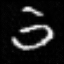

In [78]:
Image.fromarray(G_result[0,0].cpu().mul(0.5).add(0.5).mul(255).byte().numpy())

In [68]:
G_result[0].cpu().mul(0.5).add(0.5).mul(255).byte().numpy().dtype
# nn.AvgPool2d?

dtype('uint8')

In [76]:
input

Variable containing:
(0 ,.,.) = 
  0.0118  0.0078  0.1294  0.1922  0.0196  0.0078  0.0118
  0.0118  0.0118  0.1216  0.2863  0.1922  0.0000  0.0118
  0.0118  0.0118  0.0549  0.1686  0.2275  0.0784  0.0039
  0.0118  0.0275  0.2667  0.2667  0.1922  0.4902  0.0235
  0.0078  0.3412  0.2157  0.1020  0.3882  0.3216  0.0078
  0.0118  0.0745  0.2980  0.2510  0.1176  0.0000  0.0118
  0.0118  0.0000  0.0000  0.0000  0.0000  0.0118  0.0157
[torch.FloatTensor of size (1,7,7)]